In [4]:
import os
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Reading and processing data

In [8]:
dataset_root = 'data/'

train_file = os.path.join(dataset_root, 'KDDTrain+.txt')
test_file = os.path.join(dataset_root, 'KDDTest+.txt')

In [14]:
df = pd.read_csv(train_file)
df.head(5)

,0,tcp,ftp_data,SF,491,0.1,0.2,0.3,0.4,0.5,...,0.17.1,0.03,0.17.2,0.00.6,0.00.7,0.00.8,0.05,0.00.9,normal,20
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [17]:
# We see that the feature names are missing they can be obtained from
# http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
                'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 
                'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 
                'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 
                'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 
                'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 
                'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 
                'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
                'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type',
                'success_pred']


train_df = pd.read_csv(train_file, names=header_names)
train_df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,success_pred
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [61]:
# We have categorical, binary and numeric features that we want to separate
# The features are described on this site: http://kdd.ics.uci.edu/databases/kddcup99/task.html
col_names = np.array(header_names)

# protocol type, service, flag: status of connection
categorical_idx = [1, 2, 3]

# examples: root_shell, logged_in...
binary_idx = [6, 11, 13, 14, 20, 21]

# the last value is an artifact of NSL-KDD which we can ignore
# the second-to-last values is the class value 
valid_features = len(col_names) - 2

numeric_idx = list(set(range(valid_features)).difference(categorical_idx).difference(binary_idx))

categorical_cols = col_names[categorical_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

In [99]:
# We have 22 different attacks in the data set
# attack_types.txt maps them to 1 of 4 categories
#   - dos (denial of service)
#   - u2r (privilege escalation attempts)
#   - r2l (Unauthorized accesses from remote servers)
#   - probe (brute-force probing attacks)

category = defaultdict(list)
category['benign'].append('normal')
attacks = []

with open('data/attack_types.txt', 'r') as f:
    for line in f.readlines():
            attack, c = line.strip().split(' ')
            attacks.append(attack)
            category[c].append(attack)
            
attack_mapping = dict((v,k) for k in category for v in category[k])

## Generating train and test sets

In [66]:
train_df = pd.read_csv(train_file, names=header_names)

# add attack_category column 
train_df['attack_category'] = train_df['attack_type'].map(lambda x: attack_mapping[x])

# remove unusable feature
train_df.drop(['success_pred'], axis=1, inplace=True)


test_df = pd.read_csv(test_file, names=header_names)

# add attack_category column 
test_df['attack_category'] = test_df['attack_type'].map(lambda x: attack_mapping[x])

# remove unusable feature
test_df.drop(['success_pred'], axis=1, inplace=True)


## Comparing test and training data

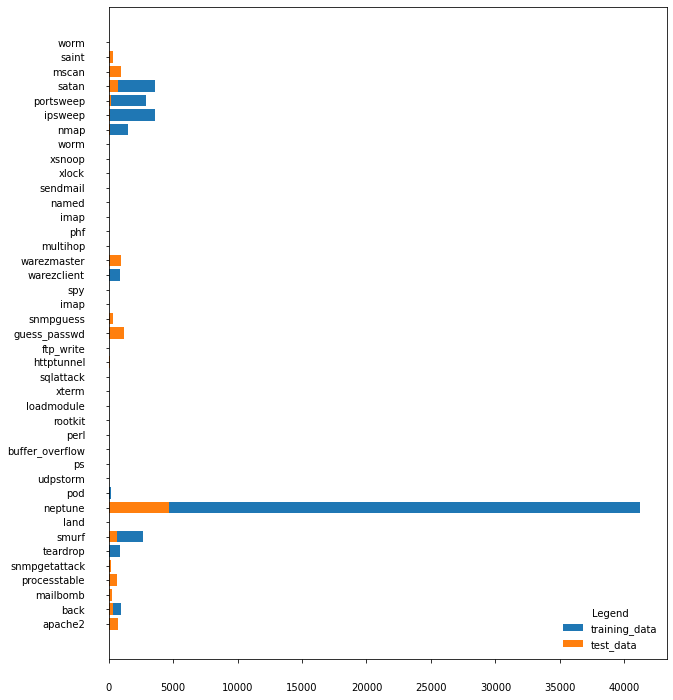

In [233]:
train_attack_types = train_df['attack_type'].value_counts()
test_attack_types = test_df['attack_type'].value_counts()


train_dd = defaultdict(int,train_attack_types.to_dict())
test_dd = defaultdict(int,test_attack_types.to_dict())

train_amount = list(map((lambda x: train_dd[x]),attacks))
test_amount = list(map((lambda x: test_dd[x]),attacks))

y_pos = np.arange(len(attacks))
plt.figure(figsize=(10, 12)) 
plt.yticks(y_pos, attacks)
plt.barh(y_pos, train_amount, align='center', label='training_data')
plt.barh(y_pos, test_amount, align='center', label='test_data')
plt.legend(loc="lower right", title="Legend", frameon=False)




We can see that the testing data actually has some novel attacks, not seen in training.
This makes sense, because for an attack detection system to be succssful it has to
also work on unseen data. This is based on the assumptions that new attacks are related
to previous one.

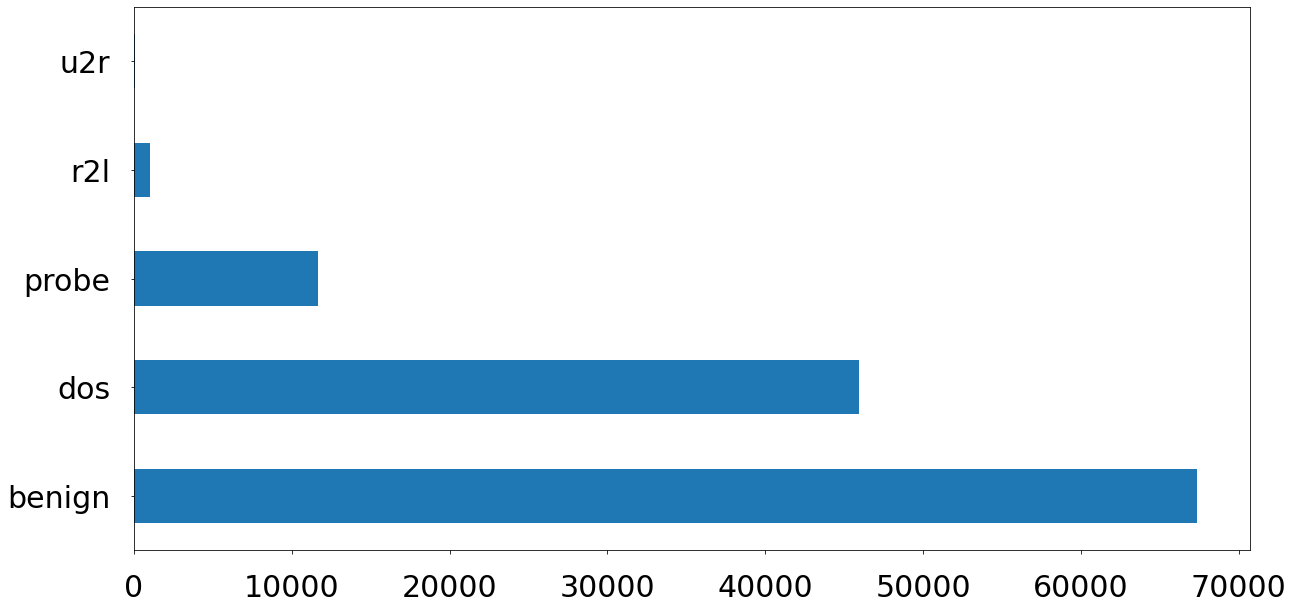

In [249]:
categories = ['benign', 'dos', 'probe', 'r2l', 'u2r']
train_attack_cats = train_df['attack_category'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()

train_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)

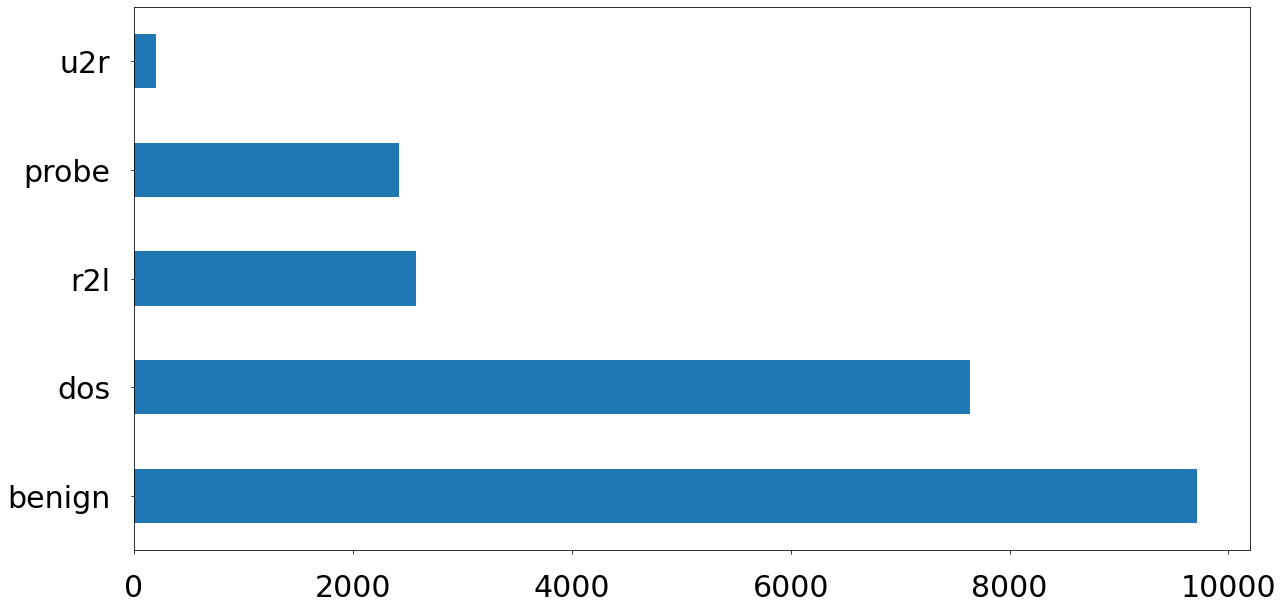

In [251]:
test_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)

When looking at the categories of the individual attacks we see that the testing data has a much higher
percentage of r2l type attacks.